In [1]:
import math
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib.axes import Axes
from torch._prims_common import DeviceLikeType
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
from tqdm.auto import tqdm, trange

from bioemu.denoiser import EulerMaruyamaPredictor
from bioemu.so3_sde import (
    DiGSO3SDE,
    angle_from_rotmat,
    rotmat_to_rotvec,
    rotvec_to_rotmat,
)
from se3diff.models import ScoreNetwork

# from se3diff.models import SO3EquivariantScoreNetwork as ScoreNetwork

In [2]:
sde = DiGSO3SDE()
model = ScoreNetwork()
mus = torch.tensor(
    [
        [[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]],
        [[0.0, -1.0, 0.0], [1.0, 0.0, 0.0], [0.0, 0.0, 1.0]],
        [[-1.0, 0.0, 0.0], [0.0, -1.0, 0.0], [0.0, 0.0, 1.0]],
    ]
)
sigmas = torch.tensor([0.1, 0.5, 0.2])
weights = torch.tensor([0.3, 0.5, 0.2])
device = "cuda" if torch.cuda.is_available() else "cpu"

Computing dlog_igso3_expansion: 100%|██████████| 1000/1000 [00:02<00:00, 488.76it/s]


$$            \nabla_\mathbf{q} = \frac{\mathbf{q}}{|\mathbf{q}|} \frac{\tfrac{\partial}{\partial |\mathbf{q}|} f_{\mathrm{IGSO(3)}}(|\mathbf{q}|)}{f_{\mathrm{IGSO(3)}}(|\mathbf{q}|)}$$
$$            \frac{1}{\lambda} = \sqrt{\frac{\sum_\omega \left[\partial_\omega \log f_\mathrm{IGSO(3)}(\omega)\right]^2 f_\mathrm{IGSO(3)}(\omega)}{3 \sum_\omega f_\mathrm{IGSO(3)}(\omega)}}$$

In [3]:
def train(
    sde: DiGSO3SDE,
    model: ScoreNetwork,
    mus: torch.Tensor,
    sigmas: torch.Tensor,
    weights: torch.Tensor,
    *,
    device: DeviceLikeType | None = None,
    epochs: int = 20,
    batch_size: int = 1024,
    n_steps: int = 200,
    lr: float = 5e-3,
    weight_decay: float = 1e-4,
    tol: float = 1e-7,
):
    # instantiate SDE and score model
    sde.to(device)
    model.to(device)

    # instantiate the mixture parameters
    mus = mus.to(device)
    sigmas = sigmas.to(device)
    weights = weights.to(device)

    optimizer = AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-5)

    for epoch in range(1, epochs + 1):
        model.train()
        epoch_loss = 0.0
        pbar = tqdm(range(n_steps), desc=f"Epoch {epoch}", leave=False)
        for _ in pbar:
            loss = _compute_batch_loss(
                sde,
                model,
                mus,
                sigmas,
                weights,
                device=device,
                batch_size=batch_size,
                tol=tol,
            )

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            l = loss.detach().item()
            epoch_loss += l
            pbar.set_postfix(loss=f"{l:.2f}")

        scheduler.step()
        avg_loss = epoch_loss / n_steps
        print(f"Epoch {epoch}: Average training loss = {avg_loss:.4f}")

        if epoch % 10 == 0:
            with torch.no_grad():
                model.eval()
                val_loss = _compute_batch_loss(
                    sde,
                    model,
                    mus,
                    sigmas,
                    weights,
                    device=device,
                    batch_size=batch_size,
                    tol=tol,
                )
            print(f"Validation loss: {val_loss:.4f}")


def _compute_batch_loss(
    sde: DiGSO3SDE,
    model: ScoreNetwork,
    mus: torch.Tensor,
    sigmas: torch.Tensor,
    weights: torch.Tensor,
    *,
    device: DeviceLikeType | None = None,
    batch_size: int = 4096,
    tol: float = 1e-7,
) -> torch.Tensor:

    # 1) draw random samples x_0 from IGSO(3) mixture
    k = torch.multinomial(weights, batch_size, replacement=True)  # (B,)
    sigma = sigmas[k]  # (B,)
    mu = mus[k]  # (B,3,3)
    r = sde.igso3.sample(sigma, num_samples=1).squeeze(-3)  # (B,3,3)
    x_0 = mu @ r  # (B,3,3)

    # 2) draw random times t from U[0,1]
    t = torch.rand(batch_size, device=device)

    # 3) get noisy rotations x_t from p_t(x | x_0)
    x_t = sde.sample_marginal(x_0, t)  # (B,3,3)

    # 4) get relative rotation vector q_t = Log(x_0^T x_t)
    # and rotation vector X_t = Log(x_t)
    q_t = rotmat_to_rotvec(torch.einsum("...ki,...kj->...ij", x_0, x_t))  # (B,3)
    X_t = rotmat_to_rotvec(x_t)  # (B,3)

    # 5) compute true score and model prediction
    true_score = sde.compute_score(q_t, t)  # (B,3)
    pred_score = model(X_t, t)  # (B,3)

    # 6) L2 denoising score‐matching loss
    loss = F.mse_loss(
        pred_score, true_score / (sde.get_score_scaling(t).unsqueeze(-1) + tol)
    )

    return loss


if __name__ == "__main__":
    train(
        sde,
        model,
        mus,
        sigmas,
        weights,
        device=device,
    )
    # save the model
    torch.save(model.state_dict(), "model.pt")
    # load the model
    model.load_state_dict(torch.load("model.pt"))

Epoch 1:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1: Average training loss = 1.0099


Epoch 2:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 2: Average training loss = 0.9693


Epoch 3:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 3: Average training loss = 0.9558


Epoch 4:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 4: Average training loss = 0.9426


Epoch 5:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 5: Average training loss = 0.9326


Epoch 6:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 6: Average training loss = 0.9350


Epoch 7:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 7: Average training loss = 0.9298


Epoch 8:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 8: Average training loss = 0.9285


Epoch 9:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 9: Average training loss = 0.9283


Epoch 10:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 10: Average training loss = 0.9309
Validation loss: 0.9338


Epoch 11:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 11: Average training loss = 0.9242


Epoch 12:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 12: Average training loss = 0.9269


Epoch 13:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 13: Average training loss = 0.9213


Epoch 14:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 14: Average training loss = 0.9248


Epoch 15:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 15: Average training loss = 0.9221


Epoch 16:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 16: Average training loss = 0.9203


Epoch 17:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 17: Average training loss = 0.9235


Epoch 18:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 18: Average training loss = 0.9178


Epoch 19:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 19: Average training loss = 0.9183


Epoch 20:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 20: Average training loss = 0.9169
Validation loss: 0.8632


In [4]:
def igso3_marginal_pdf(
    omega: torch.Tensor,
    omega_0: torch.Tensor,
    sigma: torch.Tensor,
    l_grid: torch.Tensor,
    *,
    tol: float = 1e-7,
) -> torch.Tensor:
    """
    Compute the marginal PDF of the IGSO(3) distribution.
    Args:
        omega: The angle between the two rotations.
        omega_0: The angle between the reference rotation and the first rotation.
        sigma: The standard deviation of the Gaussian noise.
        l_grid: The grid of spherical harmonics indices.
        tol: A small tolerance value to avoid division by zero.
    Returns:
        The marginal PDF of the IGSO(3) distribution.
    """

    denom_sin_0 = torch.sin(0.5 * omega_0)
    denom_sin = torch.sin(0.5 * omega)

    l_fac_1 = 2.0 * l_grid + 1.0
    l_fac_2 = -l_grid * (l_grid + 1.0)

    # Pre-compute numerator of expansion which only depends on angles.
    numerator_sin_0 = torch.sin((l_grid[None, :] + 1 / 2) * omega_0[:, None])
    numerator_sin = torch.sin((l_grid[None, :] + 1 / 2) * omega[:, None])

    exponential_term = torch.exp(l_fac_2[None, :] * sigma[:, None] ** 2 / 2)

    # Compute series expansion
    f_igso = torch.sum(exponential_term * numerator_sin * numerator_sin_0, dim=1)
    # Finalize expansion. Offset for stability can be added since omega is [0,pi] and sin(omega/2)
    # is positive in this interval.
    f_igso = f_igso * denom_sin / (denom_sin_0 + tol)

    # For small omega, accumulate limit of sine fraction instead:
    # lim[x->0] sin((l+1/2)x) / sin(x/2) = 2l + 1
    f_limw = torch.sum(exponential_term * l_fac_1[None, :] * numerator_sin, dim=1)
    f_limw = f_limw * denom_sin

    # Replace values at small omega with limit.
    f_igso = torch.where(omega_0 <= tol, f_limw, f_igso)

    # Remove remaining numerical problems
    f_igso = torch.where(
        torch.logical_or(torch.isinf(f_igso), torch.isnan(f_igso)),
        torch.zeros_like(f_igso),
        f_igso,
    )

    f_igso = f_igso * 2.0 / math.pi

    return f_igso

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

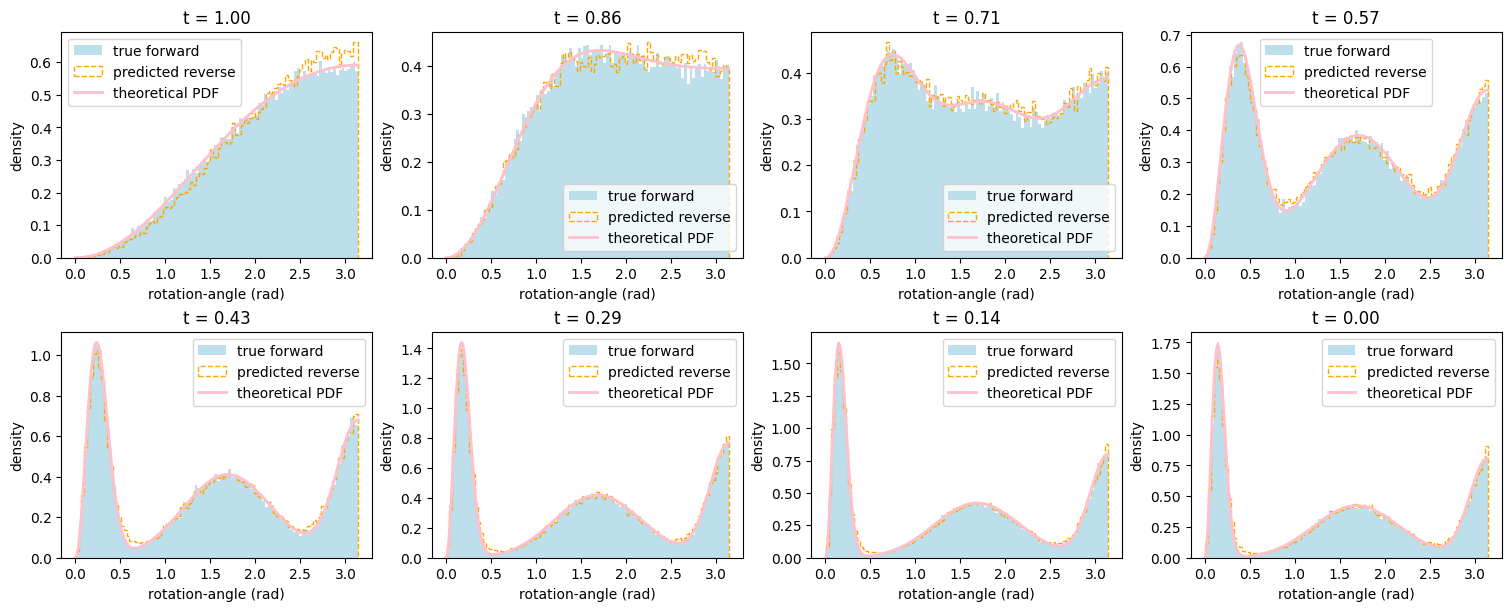

In [5]:
def reverse_diffusion(
    sde: DiGSO3SDE,
    model: ScoreNetwork,
    *,
    device: DeviceLikeType | None = None,
    batch_size: int = 1024,
    n_steps: int = 200,
) -> tuple[torch.Tensor, torch.Tensor]:
    # TODO: use heun denoiser

    sde.to(device)
    model.to(device).eval()

    x_t = sde.prior_sampling((batch_size, 3, 3), device=device)
    predictor = EulerMaruyamaPredictor(
        corruption=sde, noise_weight=1.0, marginal_concentration_factor=1.0
    )
    dt = -1.0 / n_steps
    dt_tensor = torch.tensor(dt, device=device)
    t_vals = torch.linspace(1.0, 0.0, n_steps + 1, device=device)

    xs = torch.empty((n_steps + 1, batch_size, 3, 3), device=device, dtype=x_t.dtype)
    xs[0] = x_t

    for i in trange(n_steps):
        t = t_vals[i]
        t_tensor = torch.full((batch_size,), t.item(), device=device)
        X_t = rotmat_to_rotvec(x_t)  # type: ignore
        with torch.no_grad():
            score = model(X_t, t_tensor) * sde.get_score_scaling(t_tensor).unsqueeze(-1)
        x_t, _ = predictor.update_given_score(
            x=x_t, t=t_tensor, dt=dt_tensor, batch_idx=None, score=score  # type: ignore
        )  # type: ignore
        xs[i + 1] = x_t  # type: ignore

    return xs, t_vals


def visualize_diffusion(
    sde: DiGSO3SDE,
    model: ScoreNetwork,
    mus: torch.Tensor,
    sigmas: torch.Tensor,
    weights: torch.Tensor,
    *,
    device: DeviceLikeType,
    batch_size: int = 65536,
    n_steps: int = 2000,
    t_num: int = 8,
    l_max: int = 1000,
    tol: float = 1e-7,
):
    sde.to(device)
    model.to(device).eval()

    mus = mus.to(device)
    sigmas = sigmas.to(device)
    weights = weights.to(device)

    # reverse diffusion samples
    xs, t_vals = reverse_diffusion(
        sde, model, device=device, batch_size=batch_size, n_steps=n_steps
    )

    # pick checkpoints
    idxs = np.linspace(0, n_steps, t_num, dtype=int)
    fig, axes = plt.subplots(
        2, int(np.ceil(t_num / 2)), figsize=(15, 6), constrained_layout=True
    )
    axes: np.ndarray = axes.flatten()

    # pre-sample r for true forward marginals
    k = torch.multinomial(weights, batch_size, replacement=True)  # (B,)
    sigma = sigmas[k]  # (B,)
    mu = mus[k]  # (B,3,3)
    r = sde.igso3.sample(sigma, num_samples=1).squeeze(-3)  # (B,3,3)
    x_0 = mu @ r  # (B,3,3)

    for i in trange(t_num):
        # plot forward and reverse marginals
        ax: Axes = axes[i]
        idx = idxs[i]
        t = t_vals[idx]
        t_tensor = torch.full((batch_size,), t.item(), device=device)

        # a) true forward histogram
        x_t = sde.sample_marginal(x_0, t_tensor)
        true_angles = angle_from_rotmat(x_t)[0].cpu().numpy()
        ax.hist(
            true_angles,
            bins=100,
            density=True,
            alpha=0.8,
            label="true forward",
            color="lightblue",
        )

        # b) predicted reverse histogram
        x_rev = xs[idx]
        rev_angles = angle_from_rotmat(x_rev)[0].cpu().numpy()
        ax.hist(
            rev_angles,
            bins=100,
            density=True,
            histtype="step",
            linestyle="--",
            linewidth=1,
            label="predicted reverse",
            color="orange",
        )

        # # c) theoretical forward marginal
        sigma_t = torch.sqrt(sde._marginal_std(t) ** 2 + sigmas**2)
        omega = torch.linspace(0, math.pi, 1000, device=device)
        K = mus.shape[0]
        l_grid = torch.arange(l_max, device=device)
        pdfs = torch.zeros((K, omega.shape[0]), device=device)
        for k_t in range(K):
            omega_0 = angle_from_rotmat(mus[k_t])[0].unsqueeze(0)
            sigma_k = sigma_t[k_t].unsqueeze(0)
            pdfs[k_t] = igso3_marginal_pdf(
                omega,
                omega_0,
                sigma_k,
                l_grid,
                tol=tol,
            )
        omega = omega.cpu().numpy()
        pdf = torch.sum(weights[:, None] * pdfs, dim=0).cpu().numpy()

        ax.plot(
            omega,
            pdf,
            color="pink",
            lw=2,
            label="theoretical PDF",
        )

        ax.set_title(f"t = {t:.2f}")
        ax.set_xlabel("rotation-angle (rad)")
        ax.set_ylabel("density")
        ax.legend()

    plt.show()


if __name__ == "__main__":
    model.load_state_dict(torch.load("model.pt", map_location=device))
    visualize_diffusion(sde, model, mus, sigmas, weights, device=device)